In [84]:
# !pip3 install datasets
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [85]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [86]:
# !conda install -c conda-forge cyvlfeat

In [87]:
from datasets import load_dataset

ds = load_dataset("luli0034/music-tags-to-spectrogram", split='train')

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

In [88]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import cyvlfeat
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.spatial.distance import cdist

In [89]:
BATCH_SIZE = 64
IMAGE_SIZE = 512

subset_size = int(len(ds))
subset = ds.select(range(subset_size))
print(subset)
ds = subset

Dataset({
    features: ['image', 'text'],
    num_rows: 1543
})


In [90]:
ds = ds.train_test_split(test_size=0.2)

In [91]:
ds_train, ds_test = ds["train"], ds["test"]

Посмотрим на выделение keypoints на примере маленького изображения

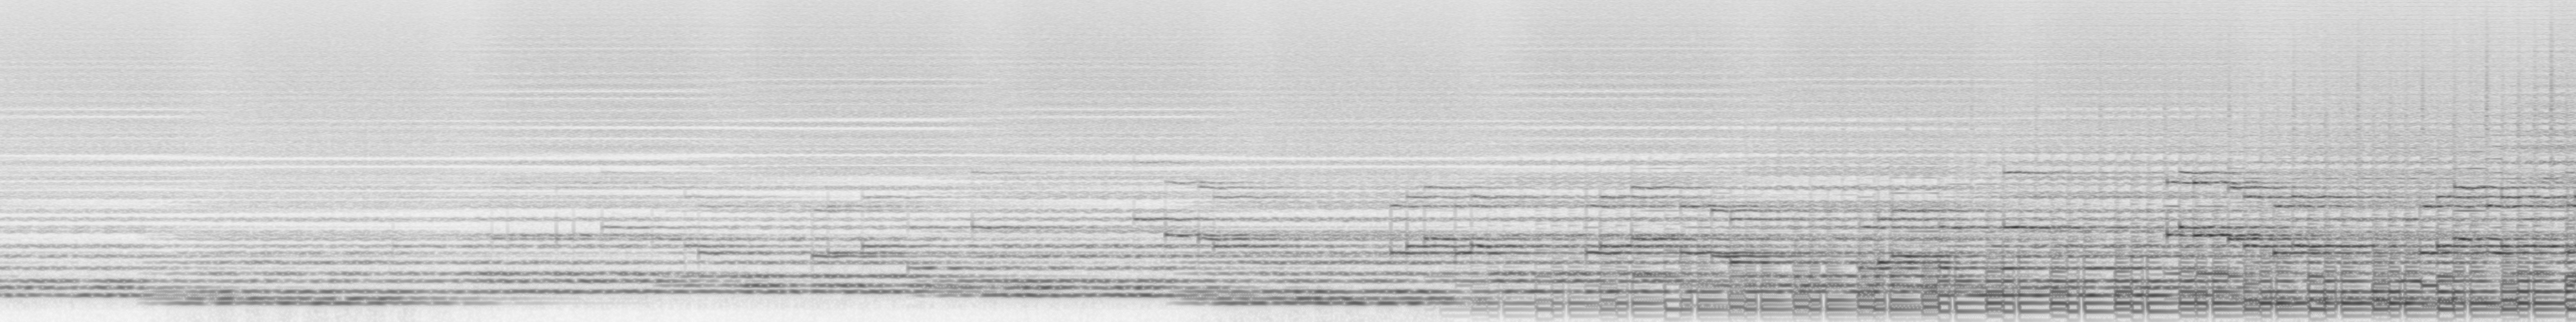

In [92]:
ds_train[0]["image"].crop((1000, 0, 5000, 500))

In [93]:
import cv2

image = ds_train[0]["image"].crop((1000, 0, 5000, 500)).convert('RGB')
image = np.array(image)
image = image[:, :, ::-1].copy()

gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray, None)

img=cv2.drawKeypoints(gray ,
                      kp ,
                      image ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('image-with-keypoints.jpg', image)

True

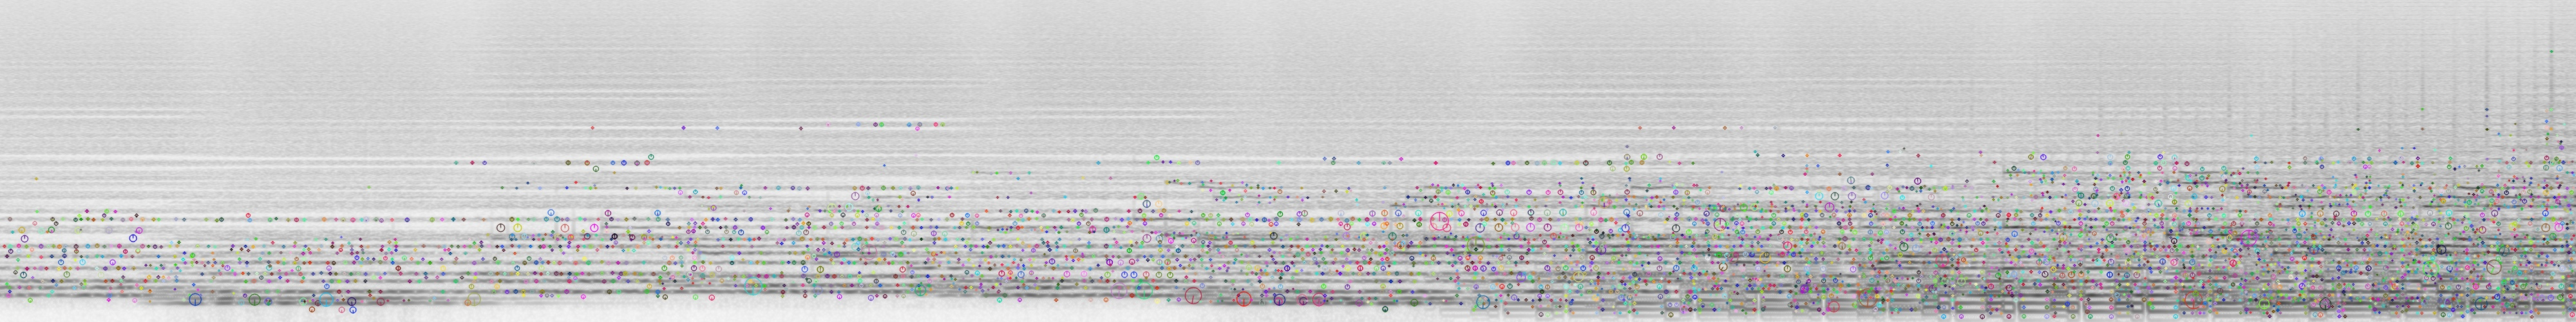

In [94]:
from IPython.display import Image
Image('image-with-keypoints.jpg')

Получили очень много векторов - будем пытаться понизить размерность по методу [отсюда](https://liverungrow.medium.com/sift-bag-of-features-svm-for-classification-b5f775d8e55f).

In [95]:
def extract_dsift_features(image):
    _, descriptors = cyvlfeat.sift.dsift(image, step=[8, 8], size=8, fast=True)
    return descriptors

def preprocess_image(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    image = cv2.resize(image, (128, 128))
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image


In [96]:
all_descriptors = []
for sample in tqdm.tqdm(ds_train):
    image = preprocess_image(sample['image'])
    descriptors = extract_dsift_features(image)
    all_descriptors.append(descriptors)

100%|██████████| 1234/1234 [08:57<00:00,  2.30it/s]


In [97]:
all_descriptors = np.vstack(all_descriptors)

In [98]:
n_clusters = 100  # Bag of Words size
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors)

KMeans(n_clusters=100, random_state=42)

In [99]:
def build_histograms(dataset, vocab):
    feats = []
    vocab_size = vocab.shape[0]

    for sample in tqdm.tqdm(dataset):
        img = preprocess_image(sample['image'])
        descriptors = extract_dsift_features(img)

        dist = cdist(descriptors, vocab, metric='euclidean')
        bin_assignment = np.argmin(dist, axis=1)

        image_feats = np.zeros(vocab_size)
        for id_assign in bin_assignment:
            image_feats[id_assign] += 1
        feats.append(image_feats)

    # Normalize histograms
    feats = np.asarray(feats)
    feats_norm_div = np.linalg.norm(feats, axis=1, keepdims=True)
    feats = feats / feats_norm_div

    return feats

In [100]:
vocab = kmeans.cluster_centers_

train_feats = build_histograms(ds_train, vocab)
test_feats = build_histograms(ds_test, vocab)

100%|██████████| 309/309 [01:58<00:00,  2.61it/s]


In [101]:
all_genres = ds_train.remove_columns('image')
all_genres_test = ds_test.remove_columns('image')
all_genres = [genre["text"].split(" ") for genre in all_genres]
all_genres_test = [genre["text"].split(" ")  for genre in all_genres_test]

In [112]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(all_genres)
y_test_encoder = mlb.transform(all_genres_test)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test_encoder, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['acidjazz', 'african', 'chanson', 'fast', 'pipeorgan', 'tribal'] will be ignored
  warnings.warn(


In [113]:
log_reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
log_reg.fit(train_feats, y_train)
y_pred_log = log_reg.predict(test_feats)

print("Logistic Regression (Multiclass) Classification Report")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (Multiclass) Classification Report
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         7
          12       0.08      0.47      0.14        17
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.07      0.56      0.13         9
          18       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          23       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [114]:
svm = SVC(kernel='linear', random_state=42, decision_function_shape='ovr')
svm.fit(train_feats, y_train)
y_pred_svm = svm.predict(test_feats)

print("SVM (Multiclass) Classification Report")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM (Multiclass) Classification Report
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         7
          12       0.08      0.47      0.14        17
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.08      0.78      0.15         9
          18       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          23       0.00      0.00      0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
